In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely import affinity
from shapely.geometry import box
import contextily as ctx


## - Carga y reproyección de todas las capas
## Se cargan los shapefiles de municipios, red vial y de estaciones IDEAM y Se reproyectan todos a EPSG 9377 (sistema métrico)
##También se realizan operaciones de limpieza o pre-procesamient

# --- File paths  ---
root_folder=r"/notebooks/"
SHAPE_MUN = root_folder+'/municipios_colombia.shp'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'
SHAPE_REDVIAL = root_folder+'/RedVial.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'

In [2]:
# Cargar las capas
gdf_mun = gpd.read_file(SHAPE_MUN) # Municipios
gdf_est = gpd.read_file(EST_CSV)
gdf_road = gpd.read_file(SHAPE_REDVIAL)
gdf_eva = gpd.read_file(EVA_CSV)

In [3]:
# Reproyectar a EPSG 9377 si no lo están ya (sistema métrico en metros)
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)
gdf_road = gpd.read_file(SHAPE_REDVIAL).to_crs(epsg=9377)

In [4]:
df_est = pd.read_csv(EST_CSV)
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

In [5]:
# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

In [6]:
print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")

1,122 municipalities • 8,973 stations • 206,068 EVA rows


In [7]:
#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

In [8]:
print(gdf_mun["STP27_PERS"].describe())  # Mínimo, máximo, media, etc.
print(gdf_mun[["MPIO_CCDGO", "MPIO_CNMBR", "STP27_PERS"]].head(10))


count    1.122000e+03
mean     3.936223e+04
std      2.424477e+05
min      1.660000e+02
25%      5.886750e+03
50%      1.135450e+04
75%      2.396675e+04
max      7.181469e+06
Name: STP27_PERS, dtype: float64
  MPIO_CCDGO              MPIO_CNMBR  STP27_PERS
0      00001               FLORENCIA    156789.0
1      00029                 ALBANIA      4514.0
2      00094  BELÉN DE LOS ANDAQUÍES      9075.0
3      00247             EL DONCELLO     17775.0
4      00256               EL PAUJÍL     13014.0
5      00410            LA MONTAÑITA     12128.0
6      00460                   MILÁN      7507.0
7      00479                 MORELIA      3350.0
8      00610     SAN JOSÉ DEL FRAGUA     11364.0
9      00860              VALPARAÍSO      6082.0


In [17]:
# Filtrar municipios del Valle del Cauca (DPTO_CCDGO == "76")
mun_valle = gdf_mun[gdf_mun["DPTO_CCDGO"] == "76"].copy()
print(mun_valle[["MPIO_CCDGO", "MPIO_CNMBR", "STP27_PERS"]].head(10))  # Mostrar primeros 10 municipios


   MPIO_CCDGO           MPIO_CNMBR  STP27_PERS
58      00001                 CALI   1822869.0
59      00036            ANDALUCÍA     18132.0
60      00041         ANSERMANUEVO     15668.0
61      00054              ARGELIA      5008.0
62      00111  GUADALAJARA DE BUGA    115821.0
63      00113         BUGALAGRANDE     22052.0
64      00122           CAICEDONIA     26357.0
65      00126               CALIMA     16054.0
66      00130           CANDELARIA     84661.0
67      00147              CARTAGO    118803.0


In [18]:
# Verifica cómo se llaman las columnas en la red  Vial
print(gdf_road.columns)
print(gdf_road.head(10))

Index(['categoria', 'codigotram', 'posterefer', 'distanciai', 'posteref_1',
       'distanciaf', 'nombreruta', 'sector', 'administra', 'grupoadmin',
       'superficie', 'calzada', 'ruta', 'fuente', 'globalid', 'nombretram',
       'created_us', 'created_da', 'last_edite', 'last_edi_1', 'territoria',
       'revisiones', 'geometry', 'longitud'],
      dtype='object')
  categoria codigotram  posterefer  distanciai  posteref_1  distanciaf  \
0         4       7006           2       750.0          11       450.0   
1         4     70CS03           1       620.0           5         0.0   
2         1     45CS04           0       920.0           3       310.0   
3         4     45CS04           0         0.0           1       920.0   
4         4      45CSE           0         0.0           1       812.0   
5         4      45CSG           0         0.0           1       138.0   
6         1       4508           0         0.0          87       306.0   
7         4       4510          34    

In [19]:
gdf_road["longitud"]=gdf_road.geometry.length
print(gdf_road.head(2))
print(gdf_road.columns)

  categoria codigotram  posterefer  distanciai  posteref_1  distanciaf  \
0         4       7006           2       750.0          11       450.0   
1         4     70CS03           1       620.0           5         0.0   

                      nombreruta                    sector administra  \
0  Acceso Troncal del  Magdalena       Aguachica – Gamarra          3   
1  Acceso Troncal del  Magdalena  Gamarra – Puerto Capulco          1   

  grupoadmin  ...                              globalid  nombretram  \
0          2  ...  7792dd5f-4f89-4e56-9196-0203604ad2ce  Por Defnir   
1          2  ...  dd5329f1-500e-43eb-b9ab-7ff2aaf25033  Por Defnir   

   created_us created_da  last_edite last_edi_1 territoria revisiones  \
0  SIG_INVIAS 2025-06-15  SIG_INVIAS 2025-06-15         26          2   
1  SIG_INVIAS 2025-06-15  SIG_INVIAS 2025-06-15         26          1   

                                            geometry      longitud  
0  LINESTRING (4918447.119 2477670.524, 4918430.9...  

In [20]:
# Verifica cómo se llaman las columnas, en especial las de latitud y longitud
print(gdf_est.columns)

Index(['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio',
       'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension',
       'Corriente', 'lat', 'lon', 'geometry'],
      dtype='object')


In [21]:
# Limpieza básica:
gdf_mun = gdf_mun.dropna(subset=["STP27_PERS"])  # Eliminar municipios sin datos de población
gdf_road = gdf_road[~gdf_road.geometry.is_empty]
gdf_est = gdf_est.dropna(subset=["Codigo"])

plt.rcParams['figure.figsize'] = (10, 8)

In [25]:
#6.2.2 Definir criterios y calcular indicadores
#Se calcularán al menos cuatro criterios:
# 1 Calcular el área (en km²) y la densidad poblacional
mun_valle["AREA"] = mun_valle.geometry.area / 1e6
mun_valle["densidad_pob"] = mun_valle["STP27_PERS"] / mun_valle["AREA"]

In [51]:
# Mostrar las primeras filas con área y densidad poblacional calculada
print(mun_valle[["MPIO_CCDGO", "MPIO_CNMBR", "AREA", "STP27_PERS", "densidad_pob"]].head(10))

   MPIO_CCDGO           MPIO_CNMBR        AREA  STP27_PERS  densidad_pob
58      00001                 CALI  563.267191   1822869.0   3236.242104
59      00036            ANDALUCÍA  110.474440     18132.0    164.128462
60      00041         ANSERMANUEVO  305.461838     15668.0     51.292823
61      00054              ARGELIA   90.805954      5008.0     55.150569
62      00111  GUADALAJARA DE BUGA  825.950698    115821.0    140.227498
63      00113         BUGALAGRANDE  396.811973     22052.0     55.572920
64      00122           CAICEDONIA  166.968704     26357.0    157.855930
65      00126               CALIMA  793.841762     16054.0     20.223174
66      00130           CANDELARIA  296.554341     84661.0    285.482248
67      00147              CARTAGO  248.214535    118803.0    478.630310


In [27]:
print(mun_valle.geometry.name)  # Debe mostrar 'geometry' como columna activa

geometry


In [28]:
print(mun_valle["STP27_PERS"].dtype)  # Debe ser float o int

float64


In [29]:
print(mun_valle["AREA"].describe())  # Rango de valores esperados


count      42.000000
mean      492.214970
std       950.958064
min        41.855447
25%       191.025395
50%       266.734218
75%       431.869519
max      6297.051380
Name: AREA, dtype: float64


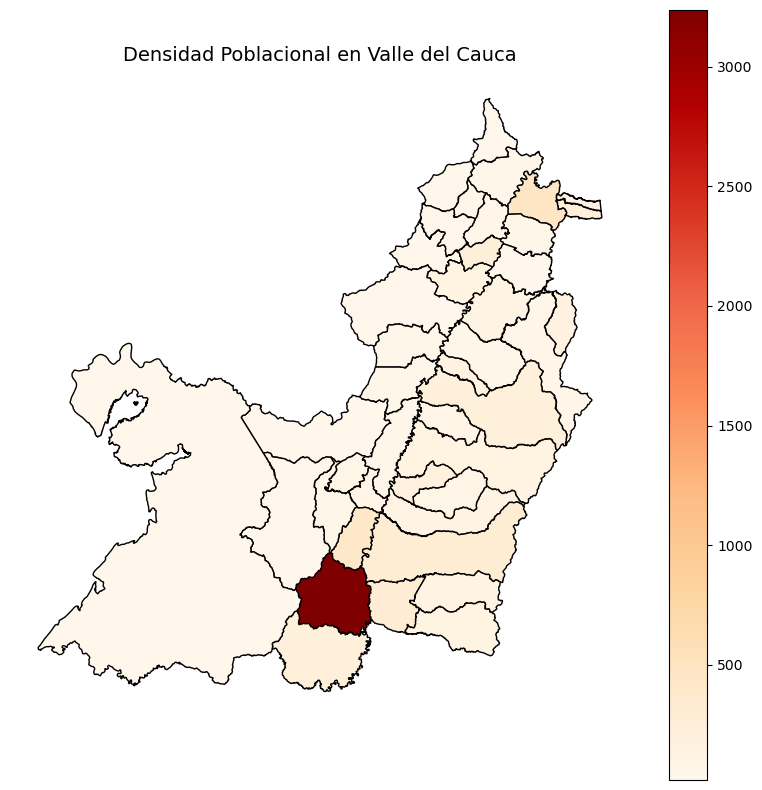

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Mapa basado en densidad poblacional
mun_valle.plot(ax=ax, column="densidad_pob", cmap="OrRd", legend=True, edgecolor="black")

# Título
ax.set_title("Densidad Poblacional en Valle del Cauca", fontsize=14)

plt.axis("off")
plt.show()


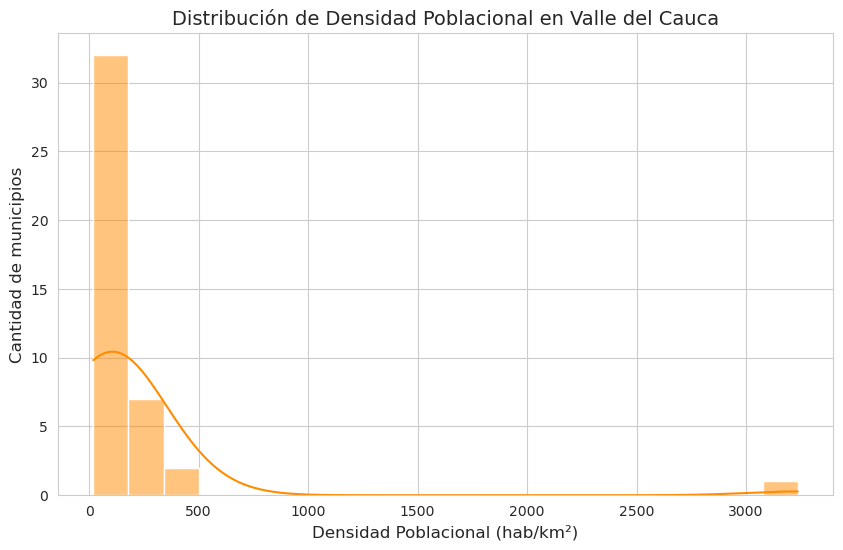

In [31]:
import seaborn as sns

# Estilo del gráfico
sns.set_style("whitegrid")

# Crear histograma
plt.figure(figsize=(10, 6))
sns.histplot(mun_valle["densidad_pob"], bins=20, kde=True, color="darkorange")

# Etiquetas
plt.xlabel("Densidad Poblacional (hab/km²)", fontsize=12)
plt.ylabel("Cantidad de municipios", fontsize=12)
plt.title("Distribución de Densidad Poblacional en Valle del Cauca", fontsize=14)

plt.show()

/tmp/ipykernel_3162/4181673331.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mun_valle_sorted["MPIO_CNMBR"], y=mun_valle_sorted["densidad_pob"], palette="OrRd")


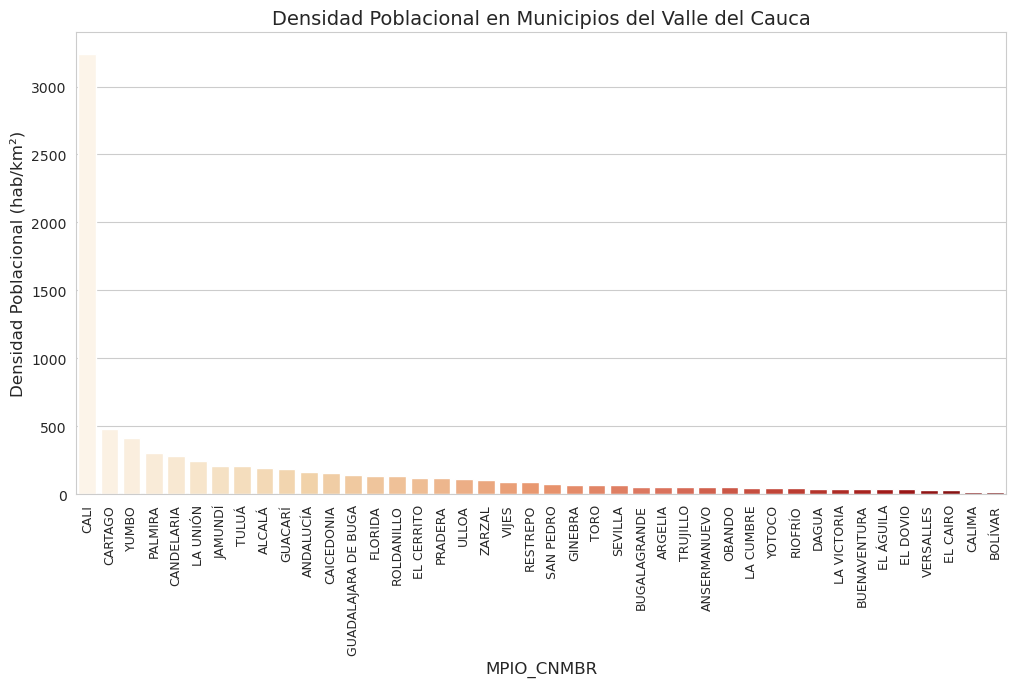

In [37]:
mun_valle_sorted = mun_valle.sort_values("densidad_pob", ascending=False)

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x=mun_valle_sorted["MPIO_CNMBR"], y=mun_valle_sorted["densidad_pob"], palette="OrRd")

# Rotar nombres y ajustar diseño
plt.xticks(rotation=90, fontsize=9)  # Rotar etiquetas para mejor visibilidad
plt.xlabel("MPIO_CNMBR", fontsize=12)
plt.ylabel("Densidad Poblacional (hab/km²)", fontsize=12)
plt.title("Densidad Poblacional en Municipios del Valle del Cauca", fontsize=14)

plt.show()


In [33]:
print(gdf_road.crs)
print(mun_valle.crs)

EPSG:9377
EPSG:9377


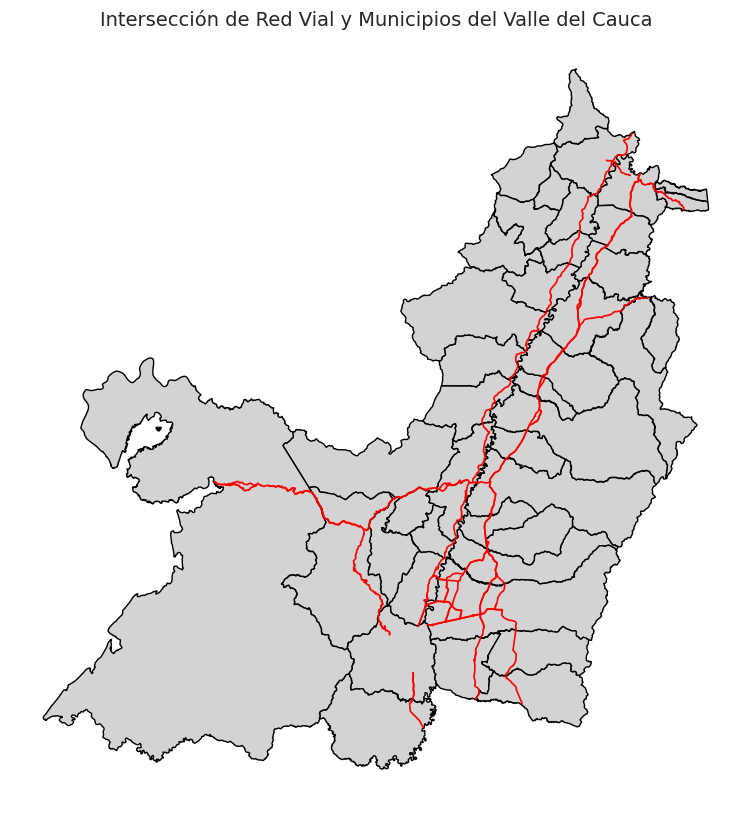

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Recortar la red vial a los municipios del Valle
vial_valle = gpd.overlay(gdf_road, mun_valle, how="intersection")

# Municipios en fondo gris claro
mun_valle.plot(ax=ax, color="lightgrey", edgecolor="black")

# Red vial recortada en rojo
vial_valle.plot(ax=ax, color="red", linewidth=1.2)

ax.set_title("Intersección de Red Vial y Municipios del Valle del Cauca", fontsize=14)
plt.axis("off")
plt.show()


In [36]:
mun_valle.columns

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9',
       'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1',
       'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_INT1',
       'S

In [38]:
# Recortar la red vial a los municipios del Valle
vial_valle = gpd.overlay(gdf_road, mun_valle, how="intersection")

# Calcular la longitud de cada vía en km
vial_valle["long_km"] = gdf_road.length / 1_000

# Agregar la longitud total por municipio (se asume un identificador único "MUN_CCDGO")
vias_por_mun = (vial_valle.groupby(["Codigo_Mun","MPIO_CNMBR"], dropna=False)["long_km"]
                .sum()
                .reset_index()
                .rename(columns={"long_km": "vial_km"}))
print(vias_por_mun)

    Codigo_Mun           MPIO_CNMBR     vial_km
0        76001                 CALI   20.521025
1        76020               ALCALÁ  113.667219
2        76036            ANDALUCÍA  192.603911
3        76041         ANSERMANUEVO   98.116258
4        76100              BOLÍVAR    2.137697
5        76109         BUENAVENTURA  269.176469
6        76111  GUADALAJARA DE BUGA  123.530954
7        76113         BUGALAGRANDE   34.308671
8        76126               CALIMA  218.757884
9        76130           CANDELARIA    8.490727
10       76147              CARTAGO  167.739861
11       76233                DAGUA  459.427827
12       76248           EL CERRITO  156.864273
13       76275              FLORIDA   14.994562
14       76306              GINEBRA    6.116159
15       76318              GUACARÍ   76.691573
16       76364              JAMUNDÍ  124.866605
17       76377            LA CUMBRE   81.199878
18       76400             LA UNIÓN    9.016438
19       76403          LA VICTORIA  141

In [42]:
print(vias_por_mun.columns[:10])   


Index(['Codigo_Mun', 'MPIO_CNMBR', 'vial_km'], dtype='object')


In [96]:
#LIMPIA RESTOS Y FUSIONA 
"""
gdf_mun = gdf_mun.drop(columns=[c for c in gdf_mun.columns
                                 if c.startswith("vial_km")],
                       errors="ignore")
"""
gdf_mun_vias= mun_valle.merge(
    vias_por_mun,
    on="Codigo_Mun",
    how="inner",
    suffixes=("", "_vias")
)
print("linea 12 \n",gdf_mun_vias)
gdf_mun_vias["vial_km"] = gdf_mun_vias["vial_km"].fillna(0)
# Unir este dato con la capa de municipios
#  DENSIDAD VIAL
# Área → km²
if gdf_mun_vias["AREA"].max() > 1e5:            # está en m²
    gdf_mun_vias["AREA_km2"] = gdf_mun_vias["AREA"] / 1_000_000
else:
    gdf_mun_vias["AREA_km2"] = gdf_mun_vias["AREA"]

gdf_mun_vias["dens_vial_km2"] = gdf_mun_vias["vial_km"] / gdf_mun_vias["AREA_km2"]

linea 12 
    DPTO_CCDGO MPIO_CCDGO           MPIO_CNMBR MPIO_CDPMP  VERSION  \
0          76      00001                 CALI      76001     2018   
1          76      00036            ANDALUCÍA      76036     2018   
2          76      00041         ANSERMANUEVO      76041     2018   
3          76      00111  GUADALAJARA DE BUGA      76111     2018   
4          76      00113         BUGALAGRANDE      76113     2018   
5          76      00126               CALIMA      76126     2018   
6          76      00130           CANDELARIA      76130     2018   
7          76      00147              CARTAGO      76147     2018   
8          76      00248           EL CERRITO      76248     2018   
9          76      00275              FLORIDA      76275     2018   
10         76      00306              GINEBRA      76306     2018   
11         76      00318              GUACARÍ      76318     2018   
12         76      00020               ALCALÁ      76020     2018   
13         76      0049

In [49]:
print(gdf_mun_vias[["MPIO_CNMBR", "vial_km", "dens_vial_km2"]].head())

            MPIO_CNMBR     vial_km  dens_vial_km2
0                 CALI   20.521025       0.036432
1            ANDALUCÍA  192.603911       1.743425
2         ANSERMANUEVO   98.116258       0.321206
3  GUADALAJARA DE BUGA  123.530954       0.149562
4         BUGALAGRANDE   34.308671       0.086461


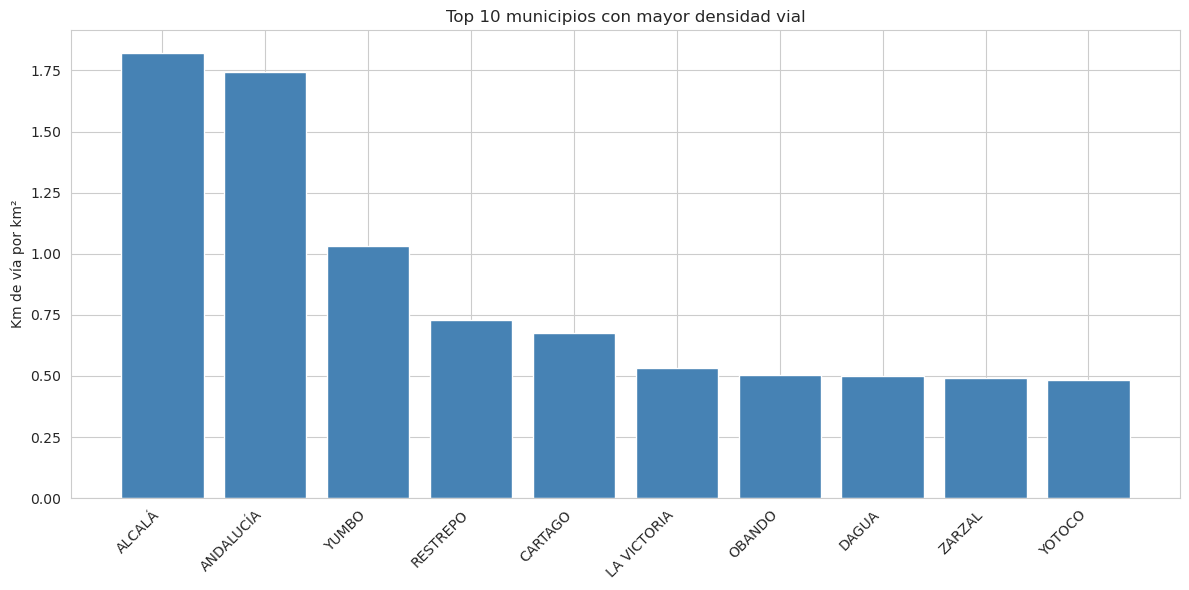

In [48]:
import matplotlib.pyplot as plt

# 🔝 Filtrar los 10 municipios con mayor densidad vial
top_10 = gdf_mun_vias.nlargest(10, "dens_vial_km2")

# 📊 Gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_10["MPIO_CNMBR"], top_10["dens_vial_km2"], color="steelblue")

# 🎨 Mejoras visuales
plt.xticks(rotation=45, ha="right")
plt.ylabel("Km de vía por km²")
plt.title("Top 10 municipios con mayor densidad vial")
plt.tight_layout()

# 🔎 Mostrar el gráfico
plt.show()

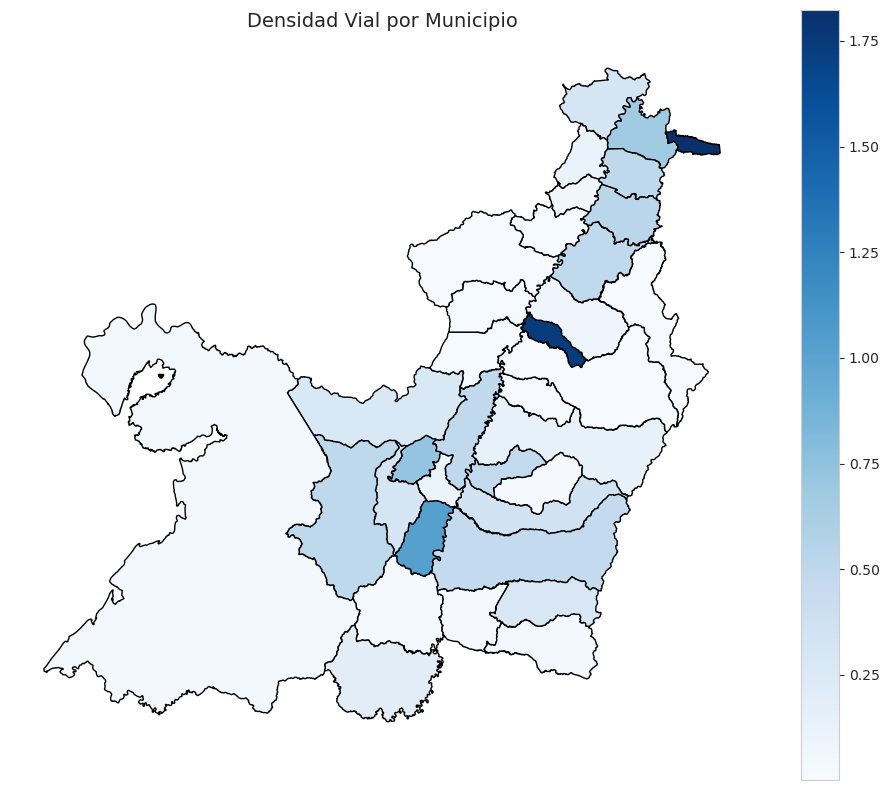

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

# Mapa de municipios con densidad vial
gdf_mun_vias.plot(ax=ax, column="dens_vial_km2", cmap="Blues", legend=True, edgecolor="black")

# Título y mejoras visuales
ax.set_title("Densidad Vial por Municipio", fontsize=14)
plt.axis("off")
plt.show()


In [55]:
# Verifica cómo se llaman las columnas, en especial las de latitud y longitud
print(gdf_est.columns)
print("mun_valle \n",mun_valle.columns)
print("gdf_mun \n",gdf_mun.columns)
print("gdf_mun \n",gdf_mun.columns)

Index(['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio',
       'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension',
       'Corriente', 'lat', 'lon', 'geometry'],
      dtype='object')
mun_valle 
 Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       '

In [60]:
# ─────────────────────────────────────────────────────────────
# 1. UNIÓN ESPACIAL: ¿qué estaciones caen dentro de cada municipio?
# ─────────────────────────────────────────────────────────────
est_en_mun = gpd.sjoin(gdf_est, mun_valle, predicate="within")

# ─────────────────────────────────────────────────────────────
# 2. NORMALIZAR LLAVE MUNICIPAL
# ─────────────────────────────────────────────────────────────
mun_key = "MPIO_CCDGO"                       # usaremos este nombre en todo el flujo

if "Codigo_Mun" in est_en_mun.columns and mun_key not in est_en_mun.columns:
    est_en_mun = est_en_mun.rename(columns={"Codigo_Mun": mun_key})

if "Codigo_Mun" in mun_valle.columns and mun_key not in mun_valle.columns:
    mun_valle = mun_valle.rename(columns={"Codigo_Mun": mun_key})

# ─────────────────────────────────────────────────────────────
# 3. CONTAR ESTACIONES POR MUNICIPIO
# ─────────────────────────────────────────────────────────────
est_count = (
    est_en_mun
      .groupby(mun_key)          # agrupar por la llave
      .size()                    # contar filas
      .reset_index(name="num_estaciones")
)

# ─────────────────────────────────────────────────────────────
# 4. LIMPIAR RESTOS PARA EVITAR COLUMNAS DUPLICADAS
# ─────────────────────────────────────────────────────────────
mun_valle = mun_valle.drop(
    columns=[c for c in mun_valle.columns if c.startswith("num_estaciones")],
    errors="ignore"
)

# ─────────────────────────────────────────────────────────────
# 5. MERGE LEFT (conserva municipios sin estaciones)
# ─────────────────────────────────────────────────────────────
mun_valle = mun_valle.merge(
    est_count,
    on=mun_key,
    how="left",
    suffixes=("", "_drop")   # sufijo de seguridad
)

# ─────────────────────────────────────────────────────────────
# 6. RELLENAR NULOS (sin chained-assignment, sin inplace)
# ─────────────────────────────────────────────────────────────
mun_valle["num_estaciones"] = (
    mun_valle["num_estaciones"].fillna(0).astype(int)
)

# ─────────────────────────────────────────────────────────────
# 7. COMPROBACIÓN RÁPIDA
# ─────────────────────────────────────────────────────────────
assert "num_estaciones" in mun_valle.columns, "❌ Falta la columna"

print(
    mun_valle[[mun_key, "MPIO_CNMBR", "num_estaciones"]]
    .sort_values("num_estaciones", ascending=False)
    .head()
)


   MPIO_CCDGO           MPIO_CNMBR  num_estaciones
19      00520              PALMIRA              92
0       00001                 CALI              84
41      00109         BUENAVENTURA              43
4       00111  GUADALAJARA DE BUGA              41
34      00895               ZARZAL              39


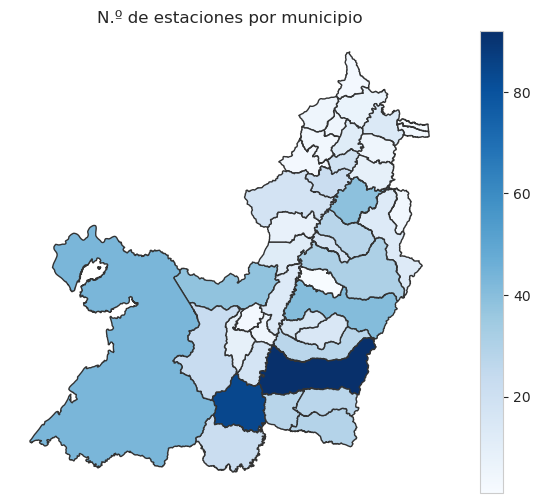

In [62]:
mun_valle.plot(column="num_estaciones", cmap="Blues", legend=True,
               figsize=(8, 6), edgecolor="0.2")
plt.title("N.º de estaciones por municipio")
plt.axis("off")
plt.show()

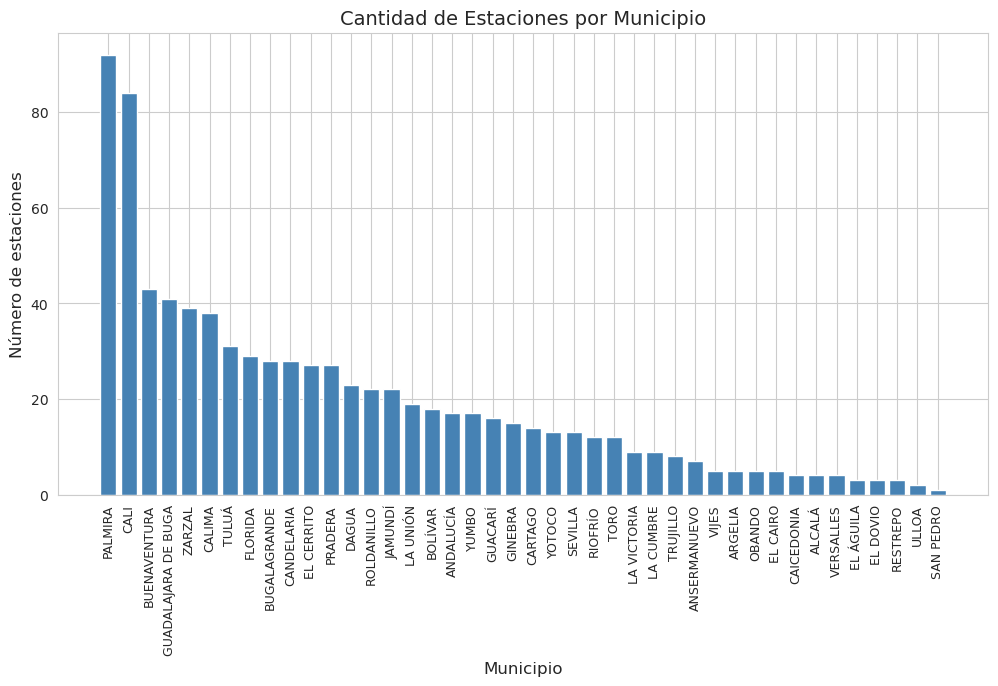

In [68]:
import matplotlib.pyplot as plt

# Ordenar municipios por número de estaciones
mun_valle_sorted = mun_valle.sort_values("num_estaciones", ascending=False)

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(mun_valle_sorted["MPIO_CNMBR"], mun_valle_sorted["num_estaciones"], color="steelblue")

# Mejoras visuales
plt.xticks(rotation=90, fontsize=9)  # Rotar etiquetas para mejor lectura
plt.xlabel("Municipio", fontsize=12)
plt.ylabel("Número de estaciones", fontsize=12)
plt.title("Cantidad de Estaciones por Municipio", fontsize=14)

plt.show()

In [63]:
# ─────────────────────────────────────────────────────────────
# 1.  CONTEO Y DENSIDAD DE ESTACIONES
# ─────────────────────────────────────────────────────────────
mun_key = "MPIO_CCDGO"                       # llave única

# Asegúrate de que est_en_mun tenga el mismo nombre de llave
if "Codigo_Mun" in est_en_mun.columns and mun_key not in est_en_mun.columns:
    est_en_mun = est_en_mun.rename(columns={"Codigo_Mun": mun_key})

# Conteo de estaciones por municipio
est_count = (
    est_en_mun.groupby(mun_key)
              .size()
              .reset_index(name="estaciones")
)

# Limpia restos de merges previos y fusiona
mun_valle = mun_valle.drop(columns=[c for c in mun_valle.columns
                                    if c.startswith("estaciones")],
                           errors="ignore")

mun_valle = mun_valle.merge(est_count, on=mun_key, how="left")
mun_valle["estaciones"] = mun_valle["estaciones"].fillna(0).astype(int)

# Calcula densidad (asumo que AREA_km2 ya existe; si no, divídela entre 1e6)
mun_valle["dens_est_km2"] = mun_valle["estaciones"] / mun_valle["AREA"]

# ─────────────────────────────────────────────────────────────
# 2.  TABLA COMPLETA (TODOS LOS MUNICIPIOS)
# ─────────────────────────────────────────────────────────────
tabla_est = (mun_valle[["MPIO_CNMBR", "estaciones", "dens_est_km2"]]
             .sort_values("dens_est_km2", ascending=False))

# Visualización “bonita” en Jupyter
from IPython.display import display
display(tabla_est.style
        .background_gradient(cmap="YlGnBu", subset=["dens_est_km2"])
        .format({"dens_est_km2": "{:.2f}"}))

# Si prefieres consola plana:
print(tabla_est.to_string(index=False, formatters={"dens_est_km2": "{:.2f}".format}))


,MPIO_CNMBR,estaciones,dens_est_km2
36,LA UNIÓN,19,0.16
1,ANDALUCÍA,17,0.15
0,CALI,84,0.15
34,ZARZAL,39,0.11
16,GUACARÍ,16,0.10
8,CANDELARIA,28,0.09
23,ROLDANILLO,22,0.09
19,PALMIRA,92,0.09
20,PRADERA,27,0.08
33,YUMBO,17,0.07


         MPIO_CNMBR  estaciones dens_est_km2
           LA UNIÓN          19         0.16
          ANDALUCÍA          17         0.15
               CALI          84         0.15
             ZARZAL          39         0.11
            GUACARÍ          16         0.10
         CANDELARIA          28         0.09
         ROLDANILLO          22         0.09
            PALMIRA          92         0.09
            PRADERA          27         0.08
              YUMBO          17         0.07
            FLORIDA          29         0.07
       BUGALAGRANDE          28         0.07
               TORO          12         0.07
             ALCALÁ           4         0.06
         EL CERRITO          27         0.06
            CARTAGO          14         0.06
            GINEBRA          15         0.06
            ARGELIA           5         0.06
GUADALAJARA DE BUGA          41         0.05
             CALIMA          38         0.05
              ULLOA           2         0.05
          

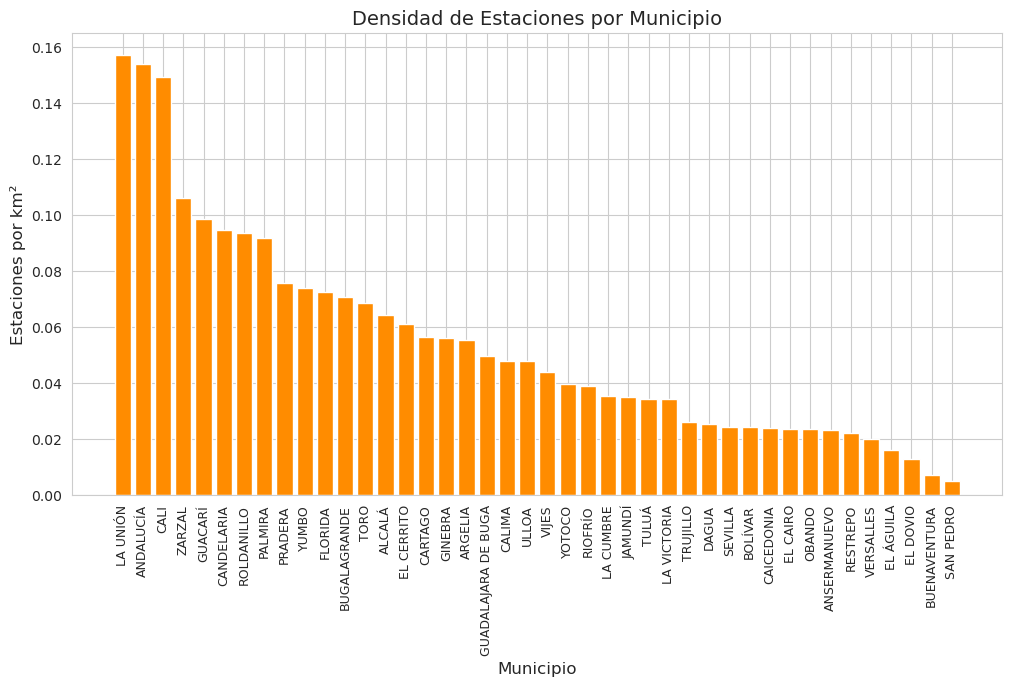

In [69]:
import matplotlib.pyplot as plt

# Ordenar municipios por densidad de estaciones
mun_valle_sorted = mun_valle.sort_values("dens_est_km2", ascending=False)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.bar(mun_valle_sorted["MPIO_CNMBR"], mun_valle_sorted["dens_est_km2"], color="darkorange")

# Mejoras visuales
plt.xticks(rotation=90, fontsize=9)
plt.xlabel("Municipio", fontsize=12)
plt.ylabel("Estaciones por km²", fontsize=12)
plt.title("Densidad de Estaciones por Municipio", fontsize=14)

plt.show()

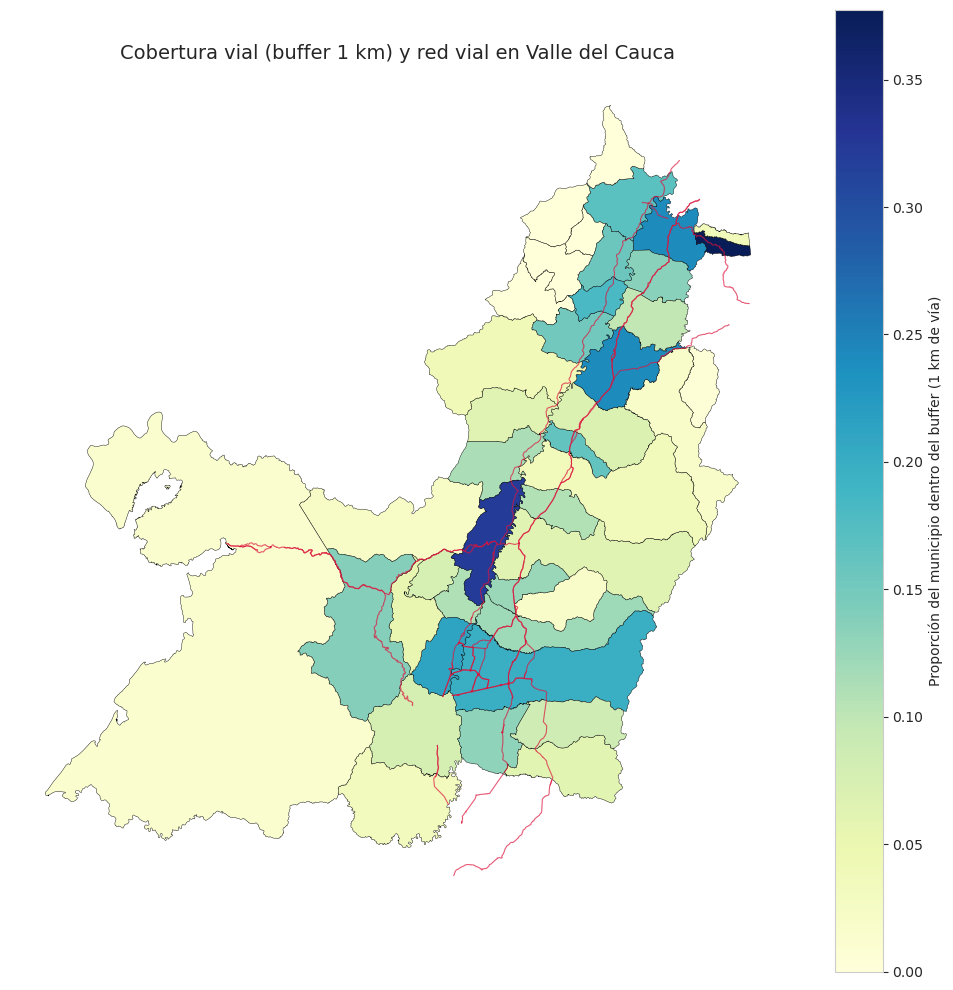

In [85]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 🏛️ Filtrar el buffer para que solo afecte los municipios del Valle
road_buffer_valle = road_buffer.intersection(mun_valle.unary_union)

# 📏 Calcular el área del buffer dentro de cada municipio
mun_valle["area_buffer"] = mun_valle.geometry.intersection(road_buffer_valle).area
mun_valle["prop_acc"] = mun_valle["area_buffer"] / mun_valle.geometry.area

# 🎨 Visualización ajustada
fig, ax = plt.subplots(figsize=(10, 10))

# Municipios coloreados según la proporción cubierta por el buffer
mun_valle.plot(
    column="prop_acc",
    cmap="YlGnBu",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Proporción del municipio dentro del buffer (1 km de vía)",
        "fmt": "{:.0%}",
    },
    ax=ax,
)

# 🚦 Superponer la red vial sobre el mapa, limitándola solo a los municipios del Valle
gdf_road_valle = gdf_road[gdf_road.intersects(mun_valle.unary_union)]  # Filtrar solo las vías dentro del Valle
gdf_road_valle.plot(ax=ax, color="crimson", linewidth=0.8, alpha=0.7)

# 🏛️ Ajustes finales
ax.set_title("Cobertura vial (buffer 1 km) y red vial en Valle del Cauca", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [89]:
print(mun_valle.columns)

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI',
       ...
       'densidad_pob', 'num_estaciones', 'estaciones', 'dens_est_km2',
       'area_buffer', 'prop_acc', 'area_buffer_m2', 'area_total_m2',
       'area_buffer_km2', 'area_total_km2'],
      dtype='object', length=103)


In [106]:
# ─────────────────────────────────────────────────────────────
# 1.  Seleccionar columnas clave del DF con vías
# ─────────────────────────────────────────────────────────────
cols_traspaso = ["Codigo_Mun", "vial_km", "AREA_km2", "dens_vial_km2"]
datos_vias = gdf_mun_vias[cols_traspaso].copy()

# ─────────────────────────────────────────────────────────────
# 2.  Fusionar con mun_valle  (añadimos sufijo de seguridad)
# ─────────────────────────────────────────────────────────────
mun_valle = mun_valle.merge(
    datos_vias,
    on="Codigo_Mun",
    how="left",
    suffixes=("", "_vias")
)

# ─────────────────────────────────────────────────────────────
# 3.  Completar campos faltantes  (sin chained assignment)
# ─────────────────────────────────────────────────────────────
# 3.a  Kilómetros de vía
mun_valle["vial_km"] = mun_valle["vial_km"].fillna(0)

# 3.b  Área en km²  (si aún no existe, créala a partir de AREA en m²)
if "AREA_km2" not in mun_valle.columns:
    mun_valle["AREA_km2"] = (
        mun_valle["AREA"] / 1_000_000
        if mun_valle["AREA"].max() > 1e5
        else mun_valle["AREA"]
    )

# 3.c  Densidad vial (km / km²)
if "dens_vial_km2" not in mun_valle.columns:
    mun_valle["dens_vial_km2"] = mun_valle["vial_km"] / mun_valle["AREA_km2"]

mun_valle["dens_vial_km2"] = mun_valle["dens_vial_km2"].fillna(0)

# ─────────────────────────────────────────────────────────────
# 4.  Verificación rápida
# ─────────────────────────────────────────────────────────────
print(
    mun_valle[["Codigo_Mun", "vial_km", "AREA_km2", "dens_vial_km2"]]
    .head()
)


   Codigo_Mun     vial_km    AREA_km2  dens_vial_km2
0       76001   20.521025  563.267191       0.036432
1       76036  192.603911  110.474440       1.743425
2       76041   98.116258  305.461838       0.321206
3       76054    0.000000         NaN       0.000000
4       76111  123.530954  825.950698       0.149562


In [113]:
print(mun_valle.columns)

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI',
       ...
       'AREA_km2', 'dens_vial_km2', 'vial_km_vias', 'AREA_km2_vias',
       'dens_vial_km2_vias', 'densidad_pob_norm', 'dens_vial_km2_norm',
       'dens_est_km2_norm', 'prop_acc_norm', 'score'],
      dtype='object', length=116)


In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Normalizar los cuatro criterios
cols_norm = ["densidad_pob", "dens_vial_km2", "dens_est_km2", "prop_acc"]
mun_valle[[c + "_norm" for c in cols_norm]] = scaler.fit_transform(mun_valle[cols_norm])

# Calcular score combinando los criterios (cada uno con peso 0.25)
mun_valle["score"] = (mun_valle["densidad_pob_norm"] * 0.4 +
                      mun_valle["dens_vial_km2_norm"] * 0.3 +
                      mun_valle["dens_est_km2_norm"] * 0.1 +
                      mun_valle["prop_acc_norm"] * 0.2)

# Ordenar los municipios por score (el mayor score indica mayor idoneidad)
mun_valle.sort_values("score", ascending=False, inplace=True)
mejor_mun_valle = mun_valle.iloc[0]
print("Municipio seleccionado:", mejor_mun_valle["MPIO_CNMBR"],
      "con score =", round(mejor_mun_valle["score"], 3))

Municipio seleccionado: ALCALÁ con score = 0.561


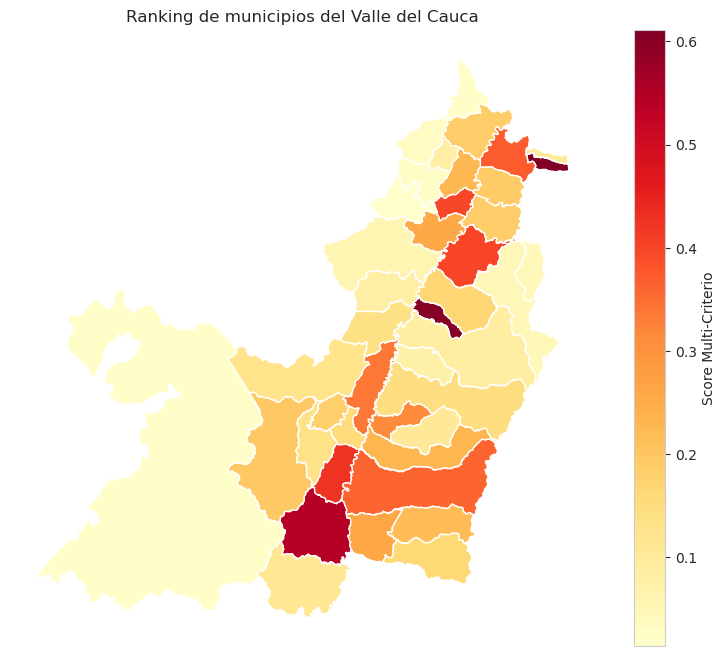

In [108]:
fig, ax = plt.subplots(figsize=(10,8))
mun_valle.plot(column="score", ax=ax, cmap="YlOrRd", legend=True,
               edgecolor="white", legend_kwds={"label": "Score Multi-Criterio"})
plt.title("Ranking de municipios del Valle del Cauca")
plt.axis("off")
plt.show()


In [114]:
# Filtrar el municipio seleccionado, usando el identificador "MUN_CCDGO"
mun_sel = gdf_mun[gdf_mun["MPIO_CCDGO"] == mejor_mun_valle["MPIO_CCDGO"]].copy()
mun_sel_geom = mun_sel.geometry.iloc[0]

In [115]:
print("🏆 Municipio seleccionado:", mun_sel["MPIO_CNMBR"].values[0])

🏆 Municipio seleccionado: ALCALÁ


In [116]:
print("🏛️ Datos del municipio seleccionado:\n")
print(mun_sel.T)  # Transpuesta para visualizar mejor las columnas como filas


🏛️ Datos del municipio seleccionado:

                                                          75   \
DPTO_CCDGO                                                 76   
MPIO_CCDGO                                              00020   
MPIO_CNMBR                                             ALCALÁ   
MPIO_CDPMP                                              76020   
VERSION                                                  2018   
...                                                       ...   
STP51_99_E                                               72.0   
Shape_Leng                                             0.4898   
Shape_Area                                           0.005078   
Codigo_Mun                                              76020   
geometry    POLYGON ((4685860.140340661 2080120.0671149672...   

                                                          971  \
DPTO_CCDGO                                                 41   
MPIO_CCDGO                                         

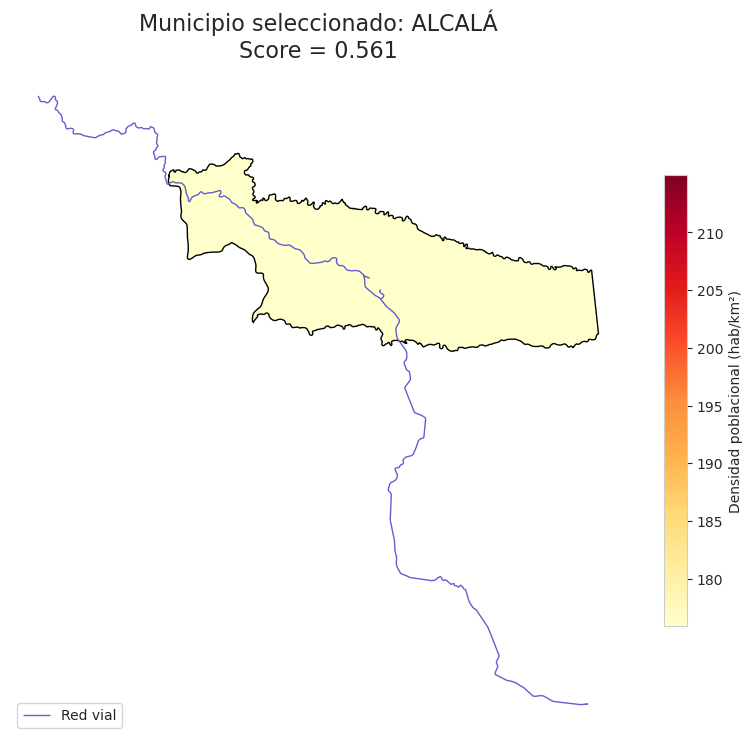

In [123]:
import matplotlib.pyplot as plt
import geopandas as gpd

# 1️⃣ Identificar el municipio mejor calificado
codigo_mejor = mejor_mun_valle["MPIO_CCDGO"]
mun_sel    = mun_valle[mun_valle["MPIO_CCDGO"] == codigo_mejor].copy()

# 2️⃣ Filtrar la red vial dentro de ese municipio
vias_sel = gdf_road[gdf_road.intersects(mun_sel.unary_union)].copy()

# 3️⃣ Crear el mapa
fig, ax = plt.subplots(figsize=(8, 8))

# ▪️ Polígono del municipio coloreado por densidad poblacional
mun_sel.plot(
    ax=ax,
    column="densidad_pob",            # hab/km²
    cmap="YlOrRd",                    # escala de amarillos-rojos
    legend=True,
    legend_kwds={
        "label": "Densidad poblacional (hab/km²)",
        "shrink": 0.6
    },
    edgecolor="black",
    linewidth=1
)

# ▪️ Sobreponer la red vial
vias_sel.plot(
    ax=ax,
    color="slateblue",
    linewidth=1,
    label="Red vial"
)

# 4️⃣ Ajustes finales
ax.set_title(
    f"Municipio seleccionado: {mun_sel['MPIO_CNMBR'].values[0]}\n"
    f"Score = {round(mejor_mun_valle['score'], 3)}",
    fontsize=16
)
ax.axis("off")
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [124]:
# Obtener los límites del municipio
minx, miny, maxx, maxy = mun_sel_geom.bounds
res = 500  # Tamaño de celda en metros

# Generar celdas (grid)
xs = np.arange(minx, maxx, res)
ys = np.arange(miny, maxy, res)
polys = []
for x in xs:
    for y in ys:
        cell = box(x, y, x + res, y + res)
        polys.append(cell)

grid = gpd.GeoDataFrame(geometry=polys, crs=mun_sel.crs)

# Clipping: recortar la malla al polígono del municipio
grid_clipped = gpd.clip(grid, mun_sel_geom)

In [125]:
# Filtrar las vías que intersectan el municipio seleccionado
roads_sel = gdf_road[gdf_road.intersects(mun_sel_geom)].copy()

# Crear un buffer de 1 km alrededor de las vías (para medir accesibilidad)
buffer_vial = roads_sel.geometry.buffer(1000).unary_union

# Para cada celda, verificar si el centroide está dentro del buffer
grid_clipped["acc_vial"] = grid_clipped.geometry.centroid.apply(lambda pt: pt.within(buffer_vial)).astype(int)

In [126]:
# Filtrar estaciones que se encuentran en el municipio
est_sel = gdf_est[gdf_est.intersects(mun_sel_geom)].copy()

# Crear buffer de 1 km alrededor de cada estación IDEAM
buffer_est = est_sel.geometry.buffer(1000).unary_union

# Comprobar si el centroide de la celda está dentro del buffer de estaciones
grid_clipped["prox_est"] = grid_clipped.geometry.centroid.apply(lambda pt: pt.within(buffer_est)).astype(int)

In [127]:
def road_length_in_cell(cell_geom, roads_layer):
    # Recortar las vías a la celda
    roads_in_cell = roads_layer[roads_layer.intersects(cell_geom)]
    if roads_in_cell.empty:
        return 0
    intersec = roads_in_cell.intersection(cell_geom)
    return intersec.length.sum() / 1000  # km

grid_clipped["vial_local_km"] = grid_clipped.geometry.apply(lambda g: road_length_in_cell(g, roads_sel))
# Densidad vial local: km de vía / área de la celda (área de celda en km²; en este caso, 0.25 km² si la celda es de 500m x 500m)
cell_area_km2 = (res * res) / 1e6
grid_clipped["dens_vial_local"] = grid_clipped["vial_local_km"] / cell_area_km2

In [128]:
# Normalizar cada criterio para el grid de celdas
scaler_local = MinMaxScaler()

# Es conveniente trabajar sobre arrays,; para las variables binarias (acc_vial y prox_est) la normalización es trivial: ya son 0 o 1.
grid_clipped["dens_vial_local_norm"] = scaler_local.fit_transform(grid_clipped[["dens_vial_local"]])

# Calcular un score de celda combinando los tres criterios
grid_clipped["cell_score"] = (grid_clipped["acc_vial"] * 0.4 +
                              grid_clipped["prox_est"] * 0.3 +
                              grid_clipped["dens_vial_local_norm"] * 0.3)
# Seleccionar la celda con el score más alto
mejor_celda = grid_clipped.sort_values("cell_score", ascending=False).iloc[0]

/tmp/ipykernel_3162/2845710752.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


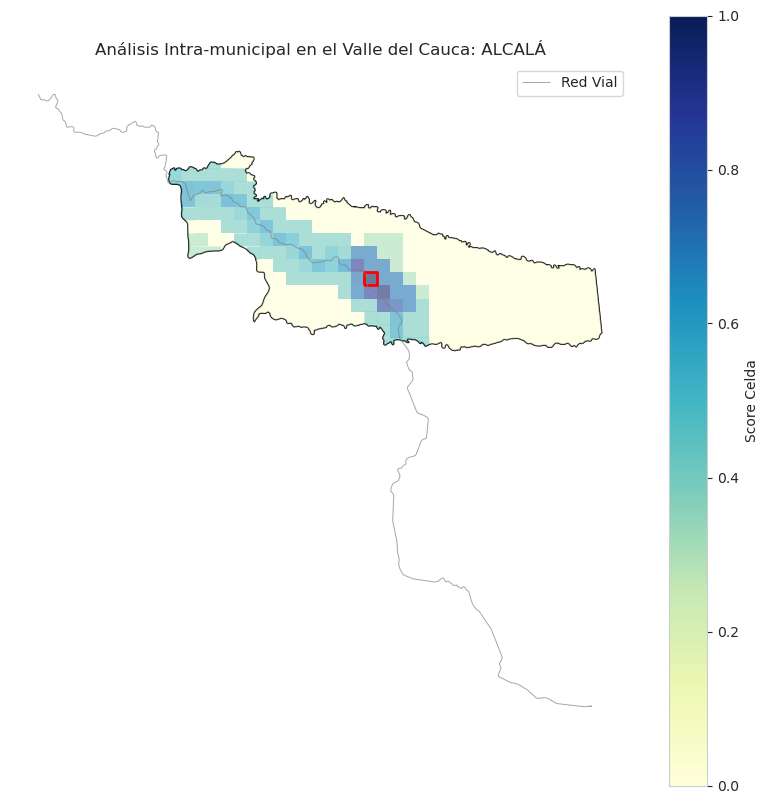

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar el polígono del municipio seleccionado
mun_sel.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, label="Municipio Seleccionado")

# Mostrar la red vial que cruza el municipio
roads_sel.plot(ax=ax, color="grey", alpha=0.7, linewidth=0.7, label="Red Vial")

# Mostrar el grid de celdas coloreado por el score local
grid_clipped.plot(ax=ax, column="cell_score", cmap="YlGnBu", alpha=0.6, edgecolor="none",
                  legend=True, legend_kwds={"label": "Score Celda"})

# Resaltar la mejor celda
gpd.GeoSeries([mejor_celda.geometry]).plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, label="Mejor Ubicación")

plt.title("Análisis Intra-municipal en el Valle del Cauca: " + mun_sel["MPIO_CNMBR"].iloc[0])
plt.legend()
plt.axis("off")
plt.show()